In [1]:
from struct import unpack, pack
import numpy

LPC = 1
LPCREFC = 2
LPCEPSTRA = 3
LPCDELCEP = 4
IREFC = 5
MFCC = 6
FBANK = 7
MELSPEC = 8
USER = 9
DISCRETE = 10
PLP = 11

_E = 0000100 # has energy
_N = 0000200 # absolute energy supressed
_D = 0000400 # has delta coefficients
_A = 0001000 # has acceleration (delta-delta) coefficients
_C = 0002000 # is compressed
_Z = 0004000 # has zero mean static coefficients
_K = 0010000 # has CRC checksum
_O = 0020000 # has 0th cepstral coefficient
_V = 0040000 # has VQ data
_T = 0100000 # has third differential coefficients

def htk_open(f, mode=None, veclen=13):
    """Open an HTK format feature file for reading or writing.
    The mode parameter is 'rb' (reading) or 'wb' (writing)."""
    if mode is None:
        if hasattr(f, 'mode'):
            mode = f.mode
        else:
            mode = 'rb'
    if mode in ('r', 'rb'):
        return HTKFeat_read(f) # veclen is ignored since it's in the file
    elif mode in ('w', 'wb'):
        return HTKFeat_write(f, veclen)
    else:
        raise Exception, "mode must be 'r', 'rb', 'w', or 'wb'"

class HTKFeat_read(object):
    "Read HTK format feature files"
    def __init__(self, filename=None):
        self.swap = (unpack('=i', pack('>i', 42))[0] != 42)
        if (filename != None):
            self.open(filename)

    def __iter__(self):
        self.fh.seek(12,0)
        return self

    def open(self, filename):
        self.filename = filename
        self.fh = file(filename, "rb")
        self.readheader()

    def readheader(self):
        self.fh.seek(0,0)
        spam = self.fh.read(12)
        self.nSamples, self.sampPeriod, self.sampSize, self.parmKind = \
                       unpack(">IIHH", spam)
        # Get coefficients for compressed data
        if self.parmKind & _C:
            self.dtype = 'h'
            self.veclen = self.sampSize / 2
            if self.parmKind & 0x3f == IREFC:
                self.A = 32767
                self.B = 0
            else:
                self.A = numpy.fromfile(self.fh, 'f', self.veclen)
                self.B = numpy.fromfile(self.fh, 'f', self.veclen)
                if self.swap:
                    self.A = self.A.byteswap()
                    self.B = self.B.byteswap()
        else:
            self.dtype = 'f'    
            self.veclen = self.sampSize / 4
        self.hdrlen = self.fh.tell()

    def seek(self, idx):
        self.fh.seek(self.hdrlen + idx * self.sampSize, 0)

    def next(self):
        vec = numpy.fromfile(self.fh, self.dtype, self.veclen)
        if len(vec) == 0:
            raise StopIteration
        if self.swap:
            vec = vec.byteswap()
        # Uncompress data to floats if required
        if self.parmKind & _C:
            vec = (vec.astype('f') + self.B) / self.A
        return vec

    def readvec(self):
        return self.next()

    def getall(self):
        self.seek(0)
        data = numpy.fromfile(self.fh, self.dtype)
        if self.parmKind & _K: # Remove and ignore checksum
            data = data[:-1]
        data = data.reshape(len(data)/self.veclen, self.veclen)
        if self.swap:
            data = data.byteswap()
        # Uncompress data to floats if required
        if self.parmKind & _C:
            data = (data.astype('f') + self.B) / self.A
        return data

class HTKFeat_write(object):
    "Write Sphinx-II format feature files"
    def __init__(self, filename=None,
                 veclen=13, sampPeriod=100000,
                 paramKind = (MFCC | _O)):
        self.veclen = veclen
        self.sampPeriod = sampPeriod
        self.sampSize = veclen * 4
        self.paramKind = paramKind
        self.dtype = 'f'
        self.filesize = 0
        self.swap = (unpack('=i', pack('>i', 42))[0] != 42)
        if (filename != None):
            self.open(filename)

    def __del__(self):
        self.close()

    def open(self, filename):
        self.filename = filename
        self.fh = file(filename, "wb")
        self.writeheader()

    def close(self):
        self.writeheader()

    def writeheader(self):
        self.fh.seek(0,0)
        self.fh.write(pack(">IIHH", self.filesize,
                           self.sampPeriod,
                           self.sampSize,
                           self.paramKind))

    def writevec(self, vec):
        if len(vec) != self.veclen:
            raise Exception("Vector length must be %d" % self.veclen)
        if self.swap:
            numpy.array(vec, self.dtype).byteswap().tofile(self.fh)
        else:
            numpy.array(vec, self.dtype).tofile(self.fh)
        self.filesize = self.filesize + self.veclen

    def writeall(self, arr):
        for row in arr:
            self.writevec(row)

 

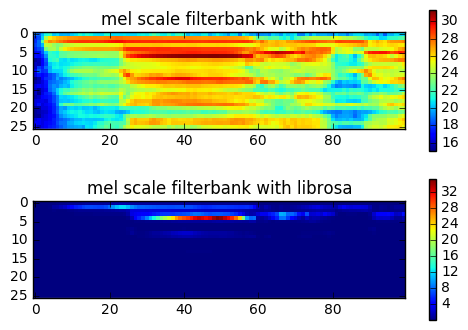

In [3]:
########### diagram 1. compare filterbank extracted with  htk and extraced with librosa


import librosa
import matplotlib.pyplot as plt         
########### extract filterbank with htk
# /usr/local/bin/HCopy -A -D -T 1 -C wav_config_default audio/vignesh.wav vignesh.fbank_no_preemf
URImfcFile = 'HTK/vignesh.config_wav_to_fbank' # change to config_wav_to_* if other parameters needed.


HTKFeat_reader =  htk_open(URImfcFile, 'rb')
mel_filterbank_htk = HTKFeat_reader.getall()
mel_filterbank_htk = mel_filterbank_htk.T
mel_filterbank_htk *= 2

plt.close()
plt.clf()
plt.subplot(2, 1, 1)
plt.imshow(mel_filterbank_htk[:,:100], interpolation='none')
plt.title('mel scale filterbank with htk')
plt.colorbar()

##### extract filterbank with librosa

y, sr = librosa.load('audio/vignesh.wav', sr=44100)
mel_filterbank_librosa = librosa.feature.melspectrogram(y=y, sr=sr, n_mels = 26, n_fft=1103, hop_length=441, htk=True)


plt.subplot(2, 1, 2)
plt.imshow(mel_filterbank_librosa[:,:100], interpolation='none')
plt.title('mel scale filterbank with librosa')
plt.colorbar()
plt.show()

In [ ]:

###### diagram 2. extract MFCCs librosa. same window and hop as in htk

import librosa
import matplotlib.pyplot as plt

y, sr = librosa.load('audio/vignesh.wav', sr=44100)

mfccs_librosa = librosa.feature.mfcc(y=y, sr=sr, n_fft=1103, hop_length=441, S= mel_filterbank, n_mfcc=13, htk=True)
mfccs_librosa  *=8 # scaling needed but dont know why...

plt.clf()
plt.subplot(2, 1, 1)
# librosa.display.specshow(mfccs_librosa, x_axis='time', n_xticks=1)
plt.imshow(mfccs_librosa[1:13,:100], interpolation='none')
plt.colorbar()
plt.title('extracted with librosa, mel step in htk )')




########## extract MFCCs with htk
# /usr/local/bin/HCopy -A -D -T 1 -C /Users/joro/Documents/Phd/UPF/voxforge/myScripts/AlignmentDuration/models_makam/input_files/wav_config_singing_yile /Users/joro/Documents/Phd/UPF/voxforge/myScripts/sms-tools/sounds/vignesh.wav /Users/joro/Documents/Phd/UPF/voxforge/myScripts/sms-tools/sounds/vignesh.mfc

URImfcFile = 'HTK/vignesh.config_wav_to_mfcc' # change to config_wav_to_mfcc_* if other parameters needed.
HTKFeat_reader =  htk_open(URImfcFile, 'rb')
mfccsFeatrues = HTKFeat_reader.getall()


plt.subplot(2, 1, 2)
# librosa.display.specshow(mfccsFeatrues_no_energy[:200,:12].T, x_axis='time', n_xticks=1)
plt.imshow(mfccsFeatrues[:100,:12].T, interpolation='none')
plt.title('extracted with htk: first 12 coeffc. exclude energy (13 coeff)')
plt.colorbar()
plt.show()


In [ ]:
|

